In [7]:
import numpy as np
import arviz as az
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
from pp_mix.interface import estimate_density_seq
from pp_mix.params_helper import make_default_strauss
import pp_mix.protos.py.params_pb2 as params_pb2


from pp_mix.state import extract_chain
from pp_mix.interface import ConditionalMCMC, estimate_density_seq, lpml, minbinder_clus
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState
from pp_mix.protos.py.params_pb2 import Params

In [8]:
params_file = "pp_mix/resources/sampler_params.asciipb"
params = Params()
with open(params_file, 'r') as fp:
    params = Params()
    text_format.Parse(fp.read(), params)

# Generate Data

In [3]:
dims = [2, 5, 10, 15, 20]
samples_per_group = 100
datas = []

for dim in dims:
    m1 = np.ones(dim) * 5
    m2 = np.ones(dim) * (-5)
    sigma = np.eye(dim)
    
    data = np.vstack(
        [mvn.rvs(mean=m1, cov=sigma, size=samples_per_group),
         mvn.rvs(mean=m2, cov=sigma, size=samples_per_group)])
    datas.append(data)

In [4]:
basefile = "data/dim_{0}_data.csv"
for data, dim in zip(datas, dims):
    np.savetxt(basefile.format(dim), data)

## RUN

In [5]:
dims = [2, 5, 10, 15, 20]
for dim in dims:
    print("Running dim {0}".format(dim))
    data = np.loadtxt("data/dim_{0}_data.csv".format(dim))
    
    strauss_params = make_default_strauss(data, 30, 5)
    strauss_params.fixed_params = True
    strauss_params.init.beta = 0.1
    strauss_params.init.gamma = 0.00000000000001

    wishart_prec_params = params_pb2.WishartParams()
    wishart_prec_params.dim = dim
    wishart_prec_params.nu = dim + 2
    wishart_prec_params.sigma = 1.0 / wishart_prec_params.nu
    wishart_prec_params.identity = True

    gamma_jump_params = params_pb2.GammaParams()
    gamma_jump_params.alpha = 1.0
    gamma_jump_params.beta = 1.0
    
    mala_stepsize = 0.01 / (dim * dim)
    
    sampler = ConditionalMCMC(pp_params=strauss_params, 
                              prec_params=wishart_prec_params,
                              jump_params=gamma_jump_params,
                              mala_stepsize=mala_stepsize)
    sampler.run(10000, 10000, 10, data)
    preds = sampler.sample_predictive()
    np.savetxt("data/ppmix_preds_dim{0}".format(dim), preds, delimiter=",")
    sampler.serialize_chains("data/chains_dim_{0}.recordio".format(dim))

Running dim 2
Burnin, iter # 200  /  10000
Burnin, iter # 400  /  10000
Burnin, iter # 600  /  10000
Burnin, iter # 800  /  10000
Burnin, iter # 1000  /  10000
Burnin, iter # 1200  /  10000
Burnin, iter # 1400  /  10000
Burnin, iter # 1600  /  10000
Burnin, iter # 1800  /  10000
Burnin, iter # 2000  /  10000
Burnin, iter # 2200  /  10000
Burnin, iter # 2400  /  10000
Burnin, iter # 2600  /  10000
Burnin, iter # 2800  /  10000
Burnin, iter # 3000  /  10000
Burnin, iter # 3200  /  10000
Burnin, iter # 3400  /  10000
Burnin, iter # 3600  /  10000
Burnin, iter # 3800  /  10000
Burnin, iter # 4000  /  10000
Burnin, iter # 4200  /  10000
Burnin, iter # 4400  /  10000
Burnin, iter # 4600  /  10000
Burnin, iter # 4800  /  10000
Burnin, iter # 5000  /  10000
Burnin, iter # 5200  /  10000
Burnin, iter # 5400  /  10000
Burnin, iter # 5600  /  10000
Burnin, iter # 5800  /  10000
Burnin, iter # 6000  /  10000
Burnin, iter # 6200  /  10000
Burnin, iter # 6400  /  10000
Burnin, iter # 6600  /  10000


Running, iter # 4200  /  10000
Running, iter # 4400  /  10000
Running, iter # 4600  /  10000
Running, iter # 4800  /  10000
Running, iter # 5000  /  10000
Running, iter # 5200  /  10000
Running, iter # 5400  /  10000
Running, iter # 5600  /  10000
Running, iter # 5800  /  10000
Running, iter # 6000  /  10000
Running, iter # 6200  /  10000
Running, iter # 6400  /  10000
Running, iter # 6600  /  10000
Running, iter # 6800  /  10000
Running, iter # 7000  /  10000
Running, iter # 7200  /  10000
Running, iter # 7400  /  10000
Running, iter # 7600  /  10000
Running, iter # 7800  /  10000
Running, iter # 8000  /  10000
Running, iter # 8200  /  10000
Running, iter # 8400  /  10000
Running, iter # 8600  /  10000
Running, iter # 8800  /  10000
Running, iter # 9000  /  10000
Running, iter # 9200  /  10000
Running, iter # 9400  /  10000
Running, iter # 9600  /  10000
Running, iter # 9800  /  10000
Running, iter # 10000  /  10000
Running dim 15
Burnin, iter # 200  /  10000
Burnin, iter # 400  /  10

In [ ]:
0.01 / (20 * 20)

In [ ]:
1e-5

# Compute ARIS

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
dims = [2, 5, 10, 25, 50]
aris = []
for dim in dims:
    chains = loadChains(
        "data/chains_dim_{0}.recordio".format(dim), MultivariateMixtureState)
    data = np.loadtxt("data/dim_{0}_data.csv".format(dim))
    ndata = data.shape[0]
    true_clus = np.concatenate([np.zeros(int(ndata / 2)), np.ones(int(ndata / 2))])
    best_clus = minbinder_clus(chains)
    aris.append(adjusted_rand_score(true_clus, best_clus))
    print(aris)

In [ ]:
aris

# Compute Wasserstein Distances

In [9]:
import ot
import pandas as pd
from sklearn.metrics import pairwise_distances

def wass(x_atoms, y_atoms):
    a = np.ones(x_atoms.shape[0])
    a /= np.sum(a)
    b = np.ones(y_atoms.shape[0])
    b /= np.sum(b)
    
    M = pairwise_distances(x_atoms, y_atoms)
    
    dist = ot.emd2(a, b, M)
    return dist

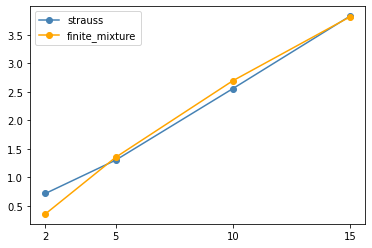

In [15]:
dims = [2, 5, 10, 15]

ppmix_w = []
ant_w = []
for dim in dims:
    data = np.loadtxt("data/dim_{0}_data.csv".format(dim))
    pp_preds = np.loadtxt("data/ppmix_preds_dim{0}".format(dim), delimiter=",")
    ant_preds = pd.read_csv("data/antman_new_preds_dim{0}.csv".format(dim), index_col=0).values
    ppmix_w.append(wass(data, pp_preds))
    ant_w.append(wass(data, ant_preds))
    
plt.plot(dims, ppmix_w, "o-", color="steelblue", label="strauss")
plt.plot(dims, ant_w, "o-", color="orange", label="finite_mixture")
plt.xticks([2, 5, 10, 15])
plt.legend()
plt.savefig("images/wass_data_pred.pdf")
plt.show()